In [49]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
from IPython.display import display

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [50]:
# Load CSV into dict of {col_name: list_of_values}

data = dict(pd.read_csv("cards/labels.csv"))


# Generate lists of allowed label values - ["red", "green", "blue"]

vocab_colour = sorted(list(set(data['colour'])))
vocab_shape = sorted(list(set(data['shape'])))
vocab_number = sorted([int(i) for i in list(set(data['number']))])
vocab_fill = sorted(list(set(data['fill'])))


# A utility function to turn an image path into a Tensor of pixel values

@tf.function
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [80, 120]) # h,w. Obviously.
    return img


# Build intermediate datasets. Labels are integer indexes into vocab lists ("red" = 0, "green" = 1, etc.)

ds_images = tf.data.Dataset.from_tensor_slices(data['file']).map(load_image).cache()

ds_colour_labels = tf.data.Dataset.from_tensor_slices([vocab_colour.index(d) for d in data['colour']])
ds_shape_labels = tf.data.Dataset.from_tensor_slices([vocab_shape.index(d) for d in data['shape']])
ds_number_labels = tf.data.Dataset.from_tensor_slices([vocab_number.index(int(d)) for d in data['number']])
ds_fill_labels = tf.data.Dataset.from_tensor_slices([vocab_fill.index(d) for d in data['fill']])


# Combine features and labels into datasets of (feature, label) pairs. There's only one feature here - the image.

ds_colour = tf.data.Dataset.zip((ds_images, ds_colour_labels)).cache()
ds_shape = tf.data.Dataset.zip((ds_images, ds_shape_labels)).cache()
ds_number = tf.data.Dataset.zip((ds_images, ds_number_labels)).cache()
ds_fill = tf.data.Dataset.zip((ds_images, ds_fill_labels)).cache()


# Split the datasets into test and training sets.

ds_colour_test = ds_colour.take(20).batch(1)
ds_colour_train = ds_colour.skip(20).batch(32)

ds_shape_test = ds_shape.take(20).batch(1)
ds_shape_train = ds_shape.skip(20).batch(32)

ds_number_test = ds_number.take(20).batch(1)
ds_number_train = ds_number.skip(20).batch(32)

ds_fill_test = ds_fill.take(20).batch(1)
ds_fill_train = ds_fill.skip(20).batch(32)

In [57]:
def get_model():
    
    # Use a simple CNN, taken directly from the Tensorflow Tutorial (https://www.tensorflow.org/tutorials/images/cnn#create_the_convolutional_base)
    
    # We add a couple of extra downsampling and convolution layers because our images are larger (to keep the shading detail)
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    # The last layer of the model has 3 units because there are three possible values for each label.
    # This is true for all four models we need, so we can use the same basic structure for all of them.
    
    model.add(tf.keras.layers.Dense(3))
    
    # We use the SparseCategoricalCrossEntropy loss function, which expects the labels to be integers (i.e. not one-hot encoded). 

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


# Generate and train a separate model for each of colour, shape, fill, number

colour_model = get_model()
shape_model = get_model()
fill_model = get_model()
number_model = get_model()

colour_model.fit(ds_colour_train, epochs=50)
shape_model.fit(ds_shape_train, epochs=50)
fill_model.fit(ds_fill_train, epochs=50)
number_model.fit(ds_number_train, epochs=50)

Epoch 1/50
24/24 [==============================] - 3s 52ms/step - loss: 10.9858 - accuracy: 0.3715
Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 0.7481 - accuracy: 0.6665
Epoch 3/50
24/24 [==============================] - 0s 6ms/step - loss: 0.4109 - accuracy: 0.8334
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1551 - accuracy: 0.9399
Epoch 5/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1036 - accuracy: 0.9664
Epoch 6/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1604 - accuracy: 0.9294
Epoch 7/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.9797
Epoch 8/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0543 - accuracy: 0.9855
Epoch 9/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0358 - accuracy: 0.9863
Epoch 10/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0494 - accuracy: 0.9740
Epoch 11/50
24/24

In [59]:
colour_model.save("models/colour")
shape_model.save("models/shape")
fill_model.save("models/fill")
number_model.save("models/number")

INFO:tensorflow:Assets written to: models/colour\assets
INFO:tensorflow:Assets written to: models/shape\assets
INFO:tensorflow:Assets written to: models/fill\assets
INFO:tensorflow:Assets written to: models/number\assets


Colour accuracy: 100.0%
Shape accuracy: 100.0%
Fill accuracy: 100.0%
Number accuracy: 100.0%

-------------
blue (100.0%)
squiggle (100.0%)
striped (100.0%)
3 (100.0%)


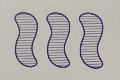

-------------
green (100.0%)
oval (100.0%)
striped (100.0%)
2 (100.0%)


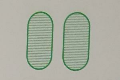

-------------
blue (100.0%)
squiggle (100.0%)
filled (100.0%)
2 (100.0%)


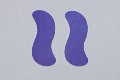

-------------
red (100.0%)
oval (100.0%)
striped (100.0%)
3 (100.0%)


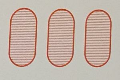

-------------
blue (100.0%)
oval (100.0%)
open (100.0%)
3 (100.0%)


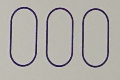

-------------
blue (100.0%)
oval (100.0%)
striped (100.0%)
2 (100.0%)


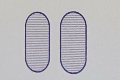

-------------
blue (100.0%)
diamond (100.0%)
filled (100.0%)
1 (100.0%)


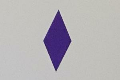

-------------
green (100.0%)
squiggle (100.0%)
striped (100.0%)
2 (100.0%)


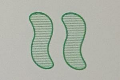

-------------
red (100.0%)
diamond (100.0%)
striped (78.8%)
3 (100.0%)


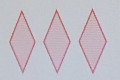

-------------
blue (100.0%)
squiggle (100.0%)
filled (100.0%)
2 (100.0%)


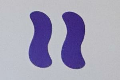

-------------
green (100.0%)
diamond (100.0%)
open (100.0%)
3 (100.0%)


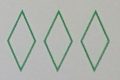

-------------
green (100.0%)
squiggle (100.0%)
striped (100.0%)
1 (100.0%)


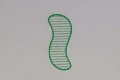

-------------
green (100.0%)
diamond (100.0%)
striped (100.0%)
2 (100.0%)


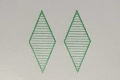

-------------
red (100.0%)
diamond (100.0%)
striped (100.0%)
3 (100.0%)


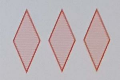

-------------
red (100.0%)
squiggle (100.0%)
filled (100.0%)
2 (100.0%)


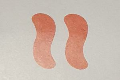

-------------
blue (99.6%)
oval (100.0%)
open (99.9%)
1 (99.9%)


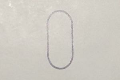

-------------
green (100.0%)
squiggle (100.0%)
filled (100.0%)
3 (100.0%)


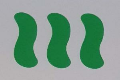

-------------
red (100.0%)
diamond (100.0%)
filled (100.0%)
1 (100.0%)


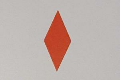

-------------
red (100.0%)
squiggle (100.0%)
striped (99.9%)
3 (100.0%)


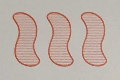

-------------
green (100.0%)
diamond (100.0%)
striped (100.0%)
3 (100.0%)


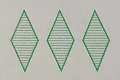

-------------


In [58]:
# Evaluate the accuracy of each model on the test set.

print(f"Colour accuracy: {dict(zip(colour_model.metrics_names, colour_model.evaluate(ds_colour_test, verbose=0)))['accuracy']:.01%}")
print(f"Shape accuracy: {dict(zip(colour_model.metrics_names, shape_model.evaluate(ds_shape_test, verbose=0)))['accuracy']:.01%}")
print(f"Fill accuracy: {dict(zip(colour_model.metrics_names, fill_model.evaluate(ds_fill_test, verbose=0)))['accuracy']:.01%}")
print(f"Number accuracy: {dict(zip(colour_model.metrics_names, number_model.evaluate(ds_number_test, verbose=0)))['accuracy']:.01%}")
print()
print("-------------")


# Display predictions (and confidence) for each card in the test set.

for card in list(ds_images.take(20).batch(1)):
    img_array = card.numpy()

    colour_predictions = colour_model(img_array)
    colour_score = tf.nn.softmax(colour_predictions[0])
    print(f"{vocab_colour[np.argmax(colour_score)]} ({np.max(colour_score):.1%})")
    
    shape_predictions = shape_model(img_array)
    shape_score = tf.nn.softmax(shape_predictions[0])
    print(f"{vocab_shape[np.argmax(shape_score)]} ({np.max(shape_score):.1%})")
    
    fill_predictions = fill_model(img_array)
    fill_score = tf.nn.softmax(fill_predictions[0])
    print(f"{vocab_fill[np.argmax(fill_score)]} ({np.max(fill_score):.1%})")
    
    number_predictions = number_model(img_array)
    number_score = tf.nn.softmax(number_predictions[0])
    print(f"{vocab_number[np.argmax(number_score)]} ({np.max(number_score):.1%})")
    

    #print(img_array[0])
    im = Image.fromarray(np.uint8(img_array[0]))
    #im.thumbnail((400,400))
    display(im)
    print("-------------")
